In [1]:
# downloading dataset from https://archive.materialscloud.org/record/2020.110
'''!wget "https://archive.materialscloud.org/record/file?file_id=b612d8e3-58af-4374-96ba-b3551ac5d2f4&filename=methane.extxyz.gz&record_id=528" -O methane.extxyz.gz
!gunzip -k methane.extxyz.gz'''

'!wget "https://archive.materialscloud.org/record/file?file_id=b612d8e3-58af-4374-96ba-b3551ac5d2f4&filename=methane.extxyz.gz&record_id=528" -O methane.extxyz.gz\n!gunzip -k methane.extxyz.gz'

In [2]:
import numpy as np
import ase.io
import tqdm
from nice.blocks import *
from nice.utilities import *
from matplotlib import pyplot as plt
import torch
torch.set_default_tensor_type(torch.DoubleTensor)
from torch import nn
import sys
sys.path.append('./code/')
from code_pytorch import *
from utilities import *
from test_utilities import *

In [3]:
HARTREE_TO_EV = 27.211386245988
FORCE_FACTOR = 51.42208619083232
LAMBDA_MAX = 5
HYPERS = {
    'interaction_cutoff': 6.3,
    'max_radial': 5,
    'max_angular': LAMBDA_MAX,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.05,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'GTO'
}
train_subset = '0:10000'
test_subset = '10000:11000'
DEVICE = 'cuda'
MAGIC_NUMBER = 10

In [4]:
train_structures = ase.io.read('methane.extxyz', index=train_subset)

test_structures = ase.io.read('methane.extxyz', index=test_subset)

all_species = get_all_species(train_structures + test_structures)

train_coefficients = get_spherical_expansion(train_structures, HYPERS,
                                             all_species, split_by_central_specie = False)

test_coefficients = get_spherical_expansion(test_structures, HYPERS,
                                            all_species, split_by_central_specie = False)


train_coefficients *= MAGIC_NUMBER
test_coefficients *= MAGIC_NUMBER
print(train_coefficients.shape)
print(test_coefficients.shape)

100%|██████████| 10/10 [00:00<00:00, 159.44it/s]

(50000, 10, 6, 11)
(5000, 10, 6, 11)


In [5]:
train_energies = [structure.info['energy'] for structure in train_structures]
train_energies = np.array(train_energies) * HARTREE_TO_EV

test_energies = [structure.info['energy'] for structure in test_structures]
test_energies = np.array(test_energies) * HARTREE_TO_EV

mean_e = np.mean(train_energies)
train_energies = train_energies - mean_e
test_energies = test_energies - mean_e

train_energies = torch.FloatTensor(train_energies).to(DEVICE)
test_energies = torch.FloatTensor(test_energies).to(DEVICE)

In [6]:
def convert_to_torch(coefficients):
    result = {}
    for lambd in range(coefficients.shape[2]):
        result[lambd] = torch.FloatTensor(coefficients[:, :, lambd, : 2 * lambd + 1])        
    return result

train_coefficients = convert_to_torch(train_coefficients)
test_coefficients = convert_to_torch(test_coefficients)

for key in train_coefficients.keys():
    print(train_coefficients[key].shape)

torch.Size([50000, 10, 1])
torch.Size([50000, 10, 3])
torch.Size([50000, 10, 5])
torch.Size([50000, 10, 7])
torch.Size([50000, 10, 9])
torch.Size([50000, 10, 11])


In [7]:
def get_loss(predictions, targets):
    delta = predictions - targets
    return torch.mean(delta * delta)

def get_mae(first, second):
    return np.mean(np.abs(first - second))

def get_rmse(first, second):
    delta = first - second
    return np.sqrt(np.mean(delta * delta))

class Model(torch.nn.Module):
    def __init__(self, input_lambda_max):
        super(Model, self).__init__()
        clebsch = nice.clebsch_gordan.ClebschGordan(input_lambda_max)
        self.clebsch_combining = ClebschCombining(clebsch.precomputed_, 0)
        self.sequential = nn.Sequential(nn.BatchNorm1d(600), nn.Linear(600, 200), nn.BatchNorm1d(200), nn.Tanh(),
                                        nn.Linear(200, 200), nn.BatchNorm1d(200), nn.Tanh(),
                                        nn.Linear(200, 1))
        
    def forward(self, X):
        X = self.clebsch_combining(X, X)[0].squeeze()        
        return {'predictions' : self.sequential(X).squeeze()}

In [8]:
model = Model(LAMBDA_MAX)
result = model(train_coefficients)
print(type(result))
print(result['predictions'].shape)

<class 'dict'>
torch.Size([50000])


In [9]:
models = {}
for key in all_species:
    models[str(key)] = Model(LAMBDA_MAX)
    

In [10]:
atomistic = Atomistic(models).to(DEVICE)
optim = torch.optim.Adam(atomistic.parameters())
train_structural_indices = get_structural_indices(train_structures)
test_structural_indices = get_structural_indices(test_structures)


train_central_species = get_central_species(train_structures)
test_central_species = get_central_species(test_structures)

train_atomic = copy.deepcopy(train_coefficients)
train_atomic['central_species'] = train_central_species

test_atomic = copy.deepcopy(test_coefficients)
test_atomic['central_species'] = test_central_species

train_struc = {'energies' : train_energies}
test_struc = {'energies' : test_energies}
#print(train_atomic[0].device)
#print(torch.is_tensor(train_atomic[0]))
BATCH_SIZE = 500
history = {'train_mae' : [], 'test_mae' : [],
           'train_rmse' : [], 'test_rmse' : []}
for epoch_num in range(100):
    train_predictions = []
    atomistic.train(True)
    for atomic_batch, structural_batch, b_struc_ind in iterate_minibatches(train_atomic, train_struc,
                                                  train_structural_indices, BATCH_SIZE, DEVICE):
        central_species_now = atomic_batch['central_species']
        coef_now = atomic_batch
        del coef_now['central_species']
        
        energies_now = structural_batch['energies']
       
        predictions = atomistic(coef_now, central_species_now, b_struc_ind)['predictions'].squeeze()
        train_predictions.append(predictions.data.cpu().numpy())       
        loss = get_loss(predictions, energies_now)
        loss.backward()
        optim.step()
        optim.zero_grad()
    atomistic.train(False)
    train_predictions = np.concatenate(train_predictions, axis = 0)
    train_mae = get_mae(train_predictions, train_energies.data.cpu().numpy())
    train_rmse = get_rmse(train_predictions, train_energies.data.cpu().numpy())
    if epoch_num % 10 == 0:
        print("train mae: ", train_mae)
        print("train rmse: ", train_rmse)
        
    test_predictions = []
    for atomic_batch, structural_batch, b_struc_ind in iterate_minibatches(test_atomic, test_struc,
                                                   test_structural_indices, BATCH_SIZE, DEVICE):
        central_species_now =  atomic_batch['central_species']
        coef_now = atomic_batch
        del coef_now['central_species']
        
        energies_now = structural_batch['energies']
        predictions = atomistic(coef_now, central_species_now, b_struc_ind)['predictions'].squeeze()
        test_predictions.append(predictions.data.cpu().numpy())
    test_predictions = np.concatenate(test_predictions, axis = 0)
    test_mae = get_mae(test_predictions, test_energies.data.cpu().numpy())
    test_rmse = get_rmse(test_predictions, test_energies.data.cpu().numpy())
    if epoch_num % 10 == 0:
        print("test mae: ", test_mae)
        print("test rmse: ", test_rmse)
    history['train_mae'].append(train_mae)
    history['test_mae'].append(test_mae)
    history['train_rmse'].append(train_rmse)
    history['test_rmse'].append(test_rmse)

train mae:  1.1585753168322501
train rmse:  1.8574056074395902
test mae:  2.2000551073543475
test rmse:  3.494420898945653
train mae:  0.38300772137227185
train rmse:  0.5230130383335805
test mae:  1.3429817967430218
test rmse:  1.4144083199023205
train mae:  0.31730760466955304
train rmse:  0.42161345885056295
test mae:  1.3047523140083157
test rmse:  1.3519335022464107
train mae:  0.2903648643410508
train rmse:  0.3821327143058382
test mae:  1.7747811608236184
test rmse:  1.814897082157868
train mae:  0.2744928645810493
train rmse:  0.35821709196787727
test mae:  2.739483244354749
test rmse:  2.766292753232224
train mae:  0.26048914623280545
train rmse:  0.338618307422872
test mae:  2.2618378760120126
test rmse:  2.295241068453526
train mae:  0.25034350195649085
train rmse:  0.32245469276015415
test mae:  2.2337834952448024
test rmse:  2.26107040420555
train mae:  0.23675450226418043
train rmse:  0.3044067829018737
test mae:  2.0322283583858307
test rmse:  2.064885380924063
train mae

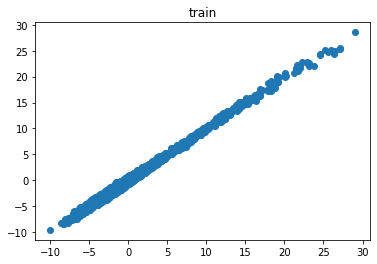

train rmse 0.2698034338887879
train mae:  0.2068674488383003


In [11]:
plt.plot(train_energies.data.cpu().numpy(), train_predictions, 'o')
plt.title("train")
plt.show()
print("train rmse", get_rmse(train_energies.data.cpu().numpy(), train_predictions))
print("train mae: ", get_mae(train_energies.data.cpu().numpy(), train_predictions))



test rmse 2.9083671546549392
test mae:  2.8901259015105962


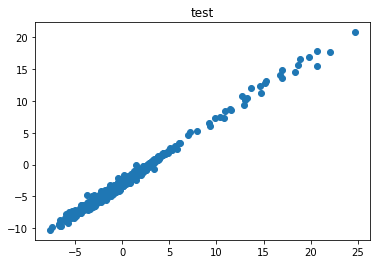

In [12]:
plt.plot(test_energies.data.cpu().numpy(), test_predictions, 'o')
plt.title("test")

print("test rmse", get_rmse(test_energies.data.cpu().numpy(), test_predictions))
print("test mae: ", get_mae(test_energies.data.cpu().numpy(), test_predictions))
plt.show()

In [13]:
for key in coef_now.keys():
    print(key, coef_now[key].shape)
    

print(coef_now[0].requires_grad)
coef_now[0].requires_grad = True
predictions = atomistic(coef_now, central_species_now, b_struc_ind)['predictions'].squeeze()


print(predictions.shape)
derivatives = torch.autograd.grad(outputs = predictions, inputs = coef_now[0], 
                                  grad_outputs = torch.ones(predictions.shape, device = DEVICE))
print(derivatives[0].shape)

0 torch.Size([2500, 10, 1])
1 torch.Size([2500, 10, 3])
2 torch.Size([2500, 10, 5])
3 torch.Size([2500, 10, 7])
4 torch.Size([2500, 10, 9])
5 torch.Size([2500, 10, 11])
False
torch.Size([500])
torch.Size([2500, 10, 1])


In [14]:
index_small = '0:500'
structures = ase.io.read('methane.extxyz', index=index_small)
coefficients = get_spherical_expansion(structures, HYPERS,
                                             all_species, split_by_central_specie = False)

coefficients *= MAGIC_NUMBER
coefficients = convert_to_torch(coefficients)
for key in coefficients.keys():
    coefficients[key] = coefficients[key].to(DEVICE)

energies =  [structure.info['energy'] for structure in structures]
energies = np.array(energies) * HARTREE_TO_EV
energies = energies - mean_e

forces = [structure.arrays["forces"] for structure in structures]
forces = np.concatenate(forces, axis = 0) * FORCE_FACTOR

structural_indices = get_structural_indices(structures)
central_species = get_central_species(structures)

for key in coefficients.keys():
    print(key, coefficients[key].shape)
print(energies.shape)
print(structural_indices.shape)
print(central_species.shape)

100%|██████████| 5/5 [00:00<00:00, 129.80it/s]

0 torch.Size([2500, 10, 1])
1 torch.Size([2500, 10, 3])
2 torch.Size([2500, 10, 5])
3 torch.Size([2500, 10, 7])
4 torch.Size([2500, 10, 9])
5 torch.Size([2500, 10, 11])
(500,)
(2500,)
(2500,)


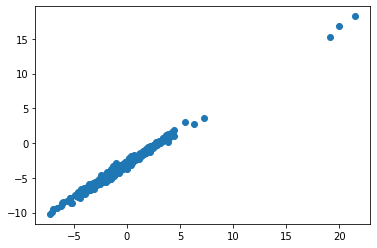

In [15]:
atomistic.train(False)
predictions = atomistic(coefficients, central_species,
                        structural_indices)['predictions'].squeeze().data.cpu().numpy()

plt.plot(energies, predictions, 'o')
plt.show()

In [16]:
coef_der_ar, central_indices, derivative_indices = \
get_numerical_derivatives(structures, all_species,\
                          HYPERS, epsilon = 1e-6)
coef_der_ar *= MAGIC_NUMBER
coef_der = {}
for l in range(coef_der_ar.shape[3]):
    coef_der[l] = coef_der_ar[:, :, :, l, :(2 * l + 1)]
    coef_der[l] = torch.from_numpy(coef_der[l]).type(torch.get_default_dtype()).to(DEVICE)

central_indices = torch.from_numpy(central_indices).to(DEVICE)
derivative_indices = torch.from_numpy(derivative_indices).to(DEVICE)
print(central_indices.shape)
print(derivative_indices.shape)
for key in coefficients.keys():
    coefficients[key].requires_grad = True
forces_predictions = atomistic.get_forces(coefficients, central_species,
                                          structural_indices, 
                                          coef_der, central_indices, derivative_indices)
print(forces_predictions.shape)

100%|██████████| 500/500 [00:00<00:00, 1515.54it/s]


torch.Size([12500])
torch.Size([12500])
torch.Size([2500, 3])


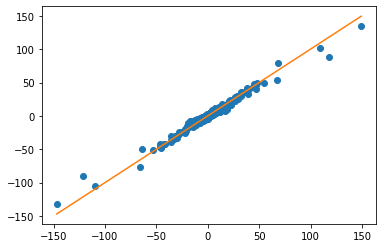

In [17]:
forces_predictions_a = forces_predictions.data.cpu().numpy().reshape([-1])
forces_a = forces.reshape([-1])
plt.plot(forces_a, forces_predictions_a, 'o')
plt.plot([np.min(forces_a), np.max(forces_a)],
         [np.min(forces_a), np.max(forces_a)])
plt.show()

In [18]:
'''print(len(test_energies))
print(get_mae(test_energies.data.cpu().numpy(), np.zeros([5000])))
print(get_rmse(test_energies.data.cpu().numpy(), np.zeros([5000])))'''

'print(len(test_energies))\nprint(get_mae(test_energies.data.cpu().numpy(), np.zeros([5000])))\nprint(get_rmse(test_energies.data.cpu().numpy(), np.zeros([5000])))'

In [19]:
print(len(history['test_mae']))
print(np.min(history['test_mae']))

100
0.31307947910694633
